In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from os import listdir
from os.path import isfile, join
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')

Using TensorFlow backend.


In [2]:
  dic_localidades = {
        'RiesgoBariloche':'Bariloche',
        'RiesgoBuenosAires':'Buenos Aires',
        'RiesgoCABACABANA':'CABA',
        'RiesgoChacoNA':'Chaco',
        'RiesgoCórdobaCórdoba':'Córdoba',
        'RiesgoEntreRiosRíos':'Entre Ríos',
        'RiesgoJujuyJujuy':'Jujuy',
        'RiesgoLaRiojaRioja':'La Rioja',
        'RiesgoMendozaMendoza':'Mendoza',
        'RiesgoNeuquénNeuquén':'Neuquén',
        'RiesgoRioNegro':'Río Negro',
        'RiesgoSaltaSalta':'Salta',
        'RiesgoSantaCruzSantaCruz':'Santa Cruz',
        'RiesgoSantaFeSantaFe':'Santa Fe',
        'RiesgoTierradelFuegoTierradel':'Tierra del Fuego',
        'RiesgoTucumanTucuman':'Tucumán'
    }

In [3]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def graph_predictions(l,df_original,y_train_pr,y_test_pr,name):
    plt.plot(df_original) 
    months_tr = np.arange(l,len(y_train_pr)+l) #meses de training
    months_ts = np.arange(len(y_train_pr)+(2*l)+1,len(df_original)-1) #meses de testing
    plt.plot(months_tr,y_train_pr,label='train') #grafico de train results
    plt.plot(months_ts,y_test_pr,label='test') #grafico de test results
    plt.title(dic_localidades[str(name)])
    plt.xlabel('Días')
    plt.ylabel('Casos/100 mil hab')
    plt.legend(fontsize=12)
    plt.savefig(dic_localidades[str(name)]+'_fit.pdf')
    plt.show()

In [6]:
seed = 7
np.random.seed(seed)

In [7]:
mypath = 'Datos'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path
df_train_total = [] #aca guardamos todos los datos

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
tw = 3

# armo scaler para los datos

In [9]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df = df[:-20]
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    df_train_total.extend(list(train_data.flatten()))

RiesgoBariloche
RiesgoBuenosAires
RiesgoCABACABANA
RiesgoChacoNA
RiesgoCórdobaCórdoba
RiesgoEntreRiosRíos
RiesgoJujuyJujuy
RiesgoLaRiojaRioja
RiesgoMendozaMendoza
RiesgoNeuquénNeuquén
RiesgoRioNegro
RiesgoSaltaSalta
RiesgoSantaCruzSantaCruz
RiesgoSantaFeSantaFe
RiesgoTierradelFuegoTierradel
RiesgoTucumanTucuman


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_total = scaler.fit_transform(np.array(df_train_total).reshape(-1,1))

# ahora armo los datos de train, test y forecast

In [11]:
df_forecast = [] #aca van a estar los datos para hacer el forecasting

In [12]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df_forecast.append(df[-20:-10])
    df = df[:-20]
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    train_data = scaler.transform(train_data.reshape(-1,1))
    test_data = scaler.transform(test_data.reshape(-1,1))
    if file == 'RiesgoBariloche':
        x_train_total, y_train_total = create_dataset(train_data,tw)
        x_test_total, y_test_total = create_dataset(test_data,tw)
    else:
        #train
        x_train, y_train = create_dataset(train_data,tw)
        x_train_total = np.vstack((x_train_total,x_train))
        y_train_total = np.hstack((y_train_total,y_train))
        #test
        x_test, y_test = create_dataset(test_data,tw)
        x_test_total = np.vstack((x_test_total,x_test))
        y_test_total = np.hstack((y_test_total,y_test))
            

RiesgoBariloche
RiesgoBuenosAires
RiesgoCABACABANA
RiesgoChacoNA
RiesgoCórdobaCórdoba
RiesgoEntreRiosRíos
RiesgoJujuyJujuy
RiesgoLaRiojaRioja
RiesgoMendozaMendoza
RiesgoNeuquénNeuquén
RiesgoRioNegro
RiesgoSaltaSalta
RiesgoSantaCruzSantaCruz
RiesgoSantaFeSantaFe
RiesgoTierradelFuegoTierradel
RiesgoTucumanTucuman


In [13]:
x_train_total = x_train_total.reshape(x_train_total.shape[0],1,x_train_total.shape[1])
x_test_total = x_test_total.reshape(x_test_total.shape[0],1,x_test_total.shape[1])

In [14]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128,activation='relu',input_shape=(1,tw))))
model.add(keras.layers.Dense(units=1))
model.compile(optimizer='adam',loss=keras.losses.MSE,metrics=['mse']) 
history = model.fit(x_train_total, y_train_total,epochs=1000,batch_size=256,validation_data=(x_test_total,y_test_total),verbose=2)

Train on 3478 samples, validate on 830 samples
Epoch 1/1000
 - 1s - loss: 0.0385 - mse: 0.0385 - val_loss: 0.6205 - val_mse: 0.6205
Epoch 2/1000
 - 0s - loss: 0.0223 - mse: 0.0223 - val_loss: 0.3160 - val_mse: 0.3160
Epoch 3/1000
 - 0s - loss: 0.0128 - mse: 0.0128 - val_loss: 0.1082 - val_mse: 0.1082
Epoch 4/1000
 - 0s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 5/1000
 - 0s - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 6/1000
 - 0s - loss: 2.7844e-04 - mse: 2.7844e-04 - val_loss: 0.0844 - val_mse: 0.0844
Epoch 7/1000
 - 0s - loss: 2.2066e-04 - mse: 2.2066e-04 - val_loss: 0.0877 - val_mse: 0.0877
Epoch 8/1000
 - 0s - loss: 1.9996e-04 - mse: 1.9996e-04 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 9/1000
 - 0s - loss: 1.8095e-04 - mse: 1.8095e-04 - val_loss: 0.0640 - val_mse: 0.0640
Epoch 10/1000
 - 0s - loss: 1.7889e-04 - mse: 1.7889e-04 - val_loss: 0.0624 - val_mse: 0.0624
Epoch 11/1000
 - 0s - loss: 1.7516e-04 - mse: 1.7516e-04 - val

Epoch 89/1000
 - 0s - loss: 7.4589e-05 - mse: 7.4589e-05 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 90/1000
 - 0s - loss: 7.2079e-05 - mse: 7.2079e-05 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 91/1000
 - 0s - loss: 6.9379e-05 - mse: 6.9379e-05 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 92/1000
 - 0s - loss: 6.9000e-05 - mse: 6.9000e-05 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 93/1000
 - 0s - loss: 6.7330e-05 - mse: 6.7330e-05 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 94/1000
 - 0s - loss: 6.3666e-05 - mse: 6.3666e-05 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 95/1000
 - 0s - loss: 6.2010e-05 - mse: 6.2010e-05 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 96/1000
 - 0s - loss: 6.0369e-05 - mse: 6.0369e-05 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 97/1000
 - 0s - loss: 5.7120e-05 - mse: 5.7120e-05 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 98/1000
 - 0s - loss: 5.5435e-05 - mse: 5.5435e-05 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 99/1000
 - 0s - loss: 5.4380e-05 - mse: 5.4380e-05 - v

Epoch 176/1000
 - 0s - loss: 1.2987e-05 - mse: 1.2987e-05 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 177/1000
 - 0s - loss: 1.3963e-05 - mse: 1.3963e-05 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 178/1000
 - 0s - loss: 1.3416e-05 - mse: 1.3416e-05 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 179/1000
 - 0s - loss: 1.2892e-05 - mse: 1.2892e-05 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 180/1000
 - 0s - loss: 1.3068e-05 - mse: 1.3068e-05 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 181/1000
 - 0s - loss: 1.3179e-05 - mse: 1.3179e-05 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 182/1000
 - 0s - loss: 1.3005e-05 - mse: 1.3005e-05 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 183/1000
 - 0s - loss: 1.2842e-05 - mse: 1.2842e-05 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 184/1000
 - 0s - loss: 1.3062e-05 - mse: 1.3062e-05 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 185/1000
 - 0s - loss: 1.2892e-05 - mse: 1.2892e-05 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 186/1000
 - 0s - loss: 1.3236e-05 - mse: 1.3

Epoch 263/1000
 - 0s - loss: 1.2838e-05 - mse: 1.2838e-05 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 264/1000
 - 0s - loss: 1.3600e-05 - mse: 1.3600e-05 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 265/1000
 - 0s - loss: 1.2489e-05 - mse: 1.2489e-05 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 266/1000
 - 0s - loss: 1.3524e-05 - mse: 1.3524e-05 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 267/1000
 - 0s - loss: 1.4203e-05 - mse: 1.4203e-05 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 268/1000
 - 0s - loss: 1.3286e-05 - mse: 1.3286e-05 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 269/1000
 - 0s - loss: 1.2360e-05 - mse: 1.2360e-05 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 270/1000
 - 0s - loss: 1.2155e-05 - mse: 1.2155e-05 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 271/1000
 - 0s - loss: 1.2423e-05 - mse: 1.2423e-05 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 272/1000
 - 0s - loss: 1.3461e-05 - mse: 1.3461e-05 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 273/1000
 - 0s - loss: 1.2372e-05 - mse: 1.2

Epoch 350/1000
 - 0s - loss: 1.2026e-05 - mse: 1.2026e-05 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 351/1000
 - 0s - loss: 1.2003e-05 - mse: 1.2003e-05 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 352/1000
 - 0s - loss: 1.3148e-05 - mse: 1.3148e-05 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 353/1000
 - 0s - loss: 1.2305e-05 - mse: 1.2305e-05 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 354/1000
 - 0s - loss: 1.2028e-05 - mse: 1.2028e-05 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 355/1000
 - 0s - loss: 1.1989e-05 - mse: 1.1989e-05 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 356/1000
 - 0s - loss: 1.2299e-05 - mse: 1.2299e-05 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 357/1000
 - 0s - loss: 1.1719e-05 - mse: 1.1719e-05 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 358/1000
 - 0s - loss: 1.3107e-05 - mse: 1.3107e-05 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 359/1000
 - 0s - loss: 1.2895e-05 - mse: 1.2895e-05 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 360/1000
 - 0s - loss: 1.3868e-05 - mse: 1.3

Epoch 436/1000
 - 0s - loss: 1.2513e-05 - mse: 1.2513e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 437/1000
 - 0s - loss: 1.3228e-05 - mse: 1.3228e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 438/1000
 - 0s - loss: 1.2919e-05 - mse: 1.2919e-05 - val_loss: 9.1940e-04 - val_mse: 9.1940e-04
Epoch 439/1000
 - 0s - loss: 1.2904e-05 - mse: 1.2904e-05 - val_loss: 9.1930e-04 - val_mse: 9.1930e-04
Epoch 440/1000
 - 0s - loss: 1.2392e-05 - mse: 1.2392e-05 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 441/1000
 - 0s - loss: 1.2391e-05 - mse: 1.2391e-05 - val_loss: 9.8214e-04 - val_mse: 9.8214e-04
Epoch 442/1000
 - 0s - loss: 1.3118e-05 - mse: 1.3118e-05 - val_loss: 9.4108e-04 - val_mse: 9.4108e-04
Epoch 443/1000
 - 0s - loss: 1.3557e-05 - mse: 1.3557e-05 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 444/1000
 - 0s - loss: 1.3180e-05 - mse: 1.3180e-05 - val_loss: 9.4809e-04 - val_mse: 9.4809e-04
Epoch 445/1000
 - 0s - loss: 1.2703e-05 - mse: 1.2703e-05 - val_loss: 8.5158e-04 - val_mse: 8.5158e-04
Ep

Epoch 517/1000
 - 0s - loss: 1.2742e-05 - mse: 1.2742e-05 - val_loss: 7.3601e-04 - val_mse: 7.3601e-04
Epoch 518/1000
 - 0s - loss: 1.2820e-05 - mse: 1.2820e-05 - val_loss: 7.1520e-04 - val_mse: 7.1520e-04
Epoch 519/1000
 - 0s - loss: 1.2382e-05 - mse: 1.2382e-05 - val_loss: 8.8287e-04 - val_mse: 8.8287e-04
Epoch 520/1000
 - 0s - loss: 1.1900e-05 - mse: 1.1900e-05 - val_loss: 7.8123e-04 - val_mse: 7.8123e-04
Epoch 521/1000
 - 0s - loss: 1.1694e-05 - mse: 1.1694e-05 - val_loss: 7.1791e-04 - val_mse: 7.1791e-04
Epoch 522/1000
 - 0s - loss: 1.1970e-05 - mse: 1.1970e-05 - val_loss: 8.2704e-04 - val_mse: 8.2704e-04
Epoch 523/1000
 - 0s - loss: 1.1962e-05 - mse: 1.1962e-05 - val_loss: 7.3139e-04 - val_mse: 7.3139e-04
Epoch 524/1000
 - 0s - loss: 1.2218e-05 - mse: 1.2218e-05 - val_loss: 8.0180e-04 - val_mse: 8.0180e-04
Epoch 525/1000
 - 0s - loss: 1.3110e-05 - mse: 1.3110e-05 - val_loss: 7.2282e-04 - val_mse: 7.2282e-04
Epoch 526/1000
 - 0s - loss: 1.1662e-05 - mse: 1.1662e-05 - val_loss: 7.5

Epoch 597/1000
 - 0s - loss: 1.2231e-05 - mse: 1.2231e-05 - val_loss: 5.7982e-04 - val_mse: 5.7982e-04
Epoch 598/1000
 - 0s - loss: 1.1255e-05 - mse: 1.1255e-05 - val_loss: 5.4607e-04 - val_mse: 5.4607e-04
Epoch 599/1000
 - 0s - loss: 1.1776e-05 - mse: 1.1776e-05 - val_loss: 5.6078e-04 - val_mse: 5.6078e-04
Epoch 600/1000
 - 0s - loss: 1.1371e-05 - mse: 1.1371e-05 - val_loss: 5.8489e-04 - val_mse: 5.8489e-04
Epoch 601/1000
 - 0s - loss: 1.1327e-05 - mse: 1.1327e-05 - val_loss: 5.5523e-04 - val_mse: 5.5523e-04
Epoch 602/1000
 - 0s - loss: 1.1668e-05 - mse: 1.1668e-05 - val_loss: 5.4204e-04 - val_mse: 5.4204e-04
Epoch 603/1000
 - 0s - loss: 1.2870e-05 - mse: 1.2870e-05 - val_loss: 5.5655e-04 - val_mse: 5.5655e-04
Epoch 604/1000
 - 0s - loss: 1.2102e-05 - mse: 1.2102e-05 - val_loss: 5.4709e-04 - val_mse: 5.4709e-04
Epoch 605/1000
 - 0s - loss: 1.1626e-05 - mse: 1.1626e-05 - val_loss: 5.4980e-04 - val_mse: 5.4980e-04
Epoch 606/1000
 - 0s - loss: 1.1894e-05 - mse: 1.1894e-05 - val_loss: 5.4

Epoch 677/1000
 - 0s - loss: 1.4221e-05 - mse: 1.4221e-05 - val_loss: 4.9911e-04 - val_mse: 4.9911e-04
Epoch 678/1000
 - 0s - loss: 1.2198e-05 - mse: 1.2198e-05 - val_loss: 5.0122e-04 - val_mse: 5.0122e-04
Epoch 679/1000
 - 0s - loss: 1.3130e-05 - mse: 1.3130e-05 - val_loss: 5.4367e-04 - val_mse: 5.4367e-04
Epoch 680/1000
 - 0s - loss: 1.2503e-05 - mse: 1.2503e-05 - val_loss: 5.0558e-04 - val_mse: 5.0558e-04
Epoch 681/1000
 - 0s - loss: 1.1534e-05 - mse: 1.1534e-05 - val_loss: 5.4751e-04 - val_mse: 5.4751e-04
Epoch 682/1000
 - 0s - loss: 1.2351e-05 - mse: 1.2351e-05 - val_loss: 4.9766e-04 - val_mse: 4.9766e-04
Epoch 683/1000
 - 0s - loss: 1.1594e-05 - mse: 1.1594e-05 - val_loss: 4.9194e-04 - val_mse: 4.9194e-04
Epoch 684/1000
 - 0s - loss: 1.3069e-05 - mse: 1.3069e-05 - val_loss: 5.2386e-04 - val_mse: 5.2386e-04
Epoch 685/1000
 - 0s - loss: 1.2414e-05 - mse: 1.2414e-05 - val_loss: 5.0007e-04 - val_mse: 5.0007e-04
Epoch 686/1000
 - 0s - loss: 1.1929e-05 - mse: 1.1929e-05 - val_loss: 5.1

Epoch 757/1000
 - 0s - loss: 1.1767e-05 - mse: 1.1767e-05 - val_loss: 5.0880e-04 - val_mse: 5.0880e-04
Epoch 758/1000
 - 0s - loss: 1.1221e-05 - mse: 1.1221e-05 - val_loss: 5.2297e-04 - val_mse: 5.2297e-04
Epoch 759/1000
 - 0s - loss: 1.1254e-05 - mse: 1.1254e-05 - val_loss: 5.2015e-04 - val_mse: 5.2015e-04
Epoch 760/1000
 - 0s - loss: 1.1477e-05 - mse: 1.1478e-05 - val_loss: 4.7365e-04 - val_mse: 4.7365e-04
Epoch 761/1000
 - 0s - loss: 1.1485e-05 - mse: 1.1485e-05 - val_loss: 5.2222e-04 - val_mse: 5.2222e-04
Epoch 762/1000
 - 0s - loss: 1.2178e-05 - mse: 1.2178e-05 - val_loss: 4.7825e-04 - val_mse: 4.7825e-04
Epoch 763/1000
 - 0s - loss: 1.2317e-05 - mse: 1.2317e-05 - val_loss: 5.5720e-04 - val_mse: 5.5720e-04
Epoch 764/1000
 - 0s - loss: 1.1365e-05 - mse: 1.1365e-05 - val_loss: 4.7954e-04 - val_mse: 4.7954e-04
Epoch 765/1000
 - 0s - loss: 1.1125e-05 - mse: 1.1125e-05 - val_loss: 5.5737e-04 - val_mse: 5.5737e-04
Epoch 766/1000
 - 0s - loss: 1.3455e-05 - mse: 1.3455e-05 - val_loss: 4.8

Epoch 837/1000
 - 0s - loss: 1.2082e-05 - mse: 1.2082e-05 - val_loss: 4.9922e-04 - val_mse: 4.9922e-04
Epoch 838/1000
 - 0s - loss: 1.2455e-05 - mse: 1.2455e-05 - val_loss: 5.8679e-04 - val_mse: 5.8679e-04
Epoch 839/1000
 - 0s - loss: 1.2744e-05 - mse: 1.2744e-05 - val_loss: 5.1029e-04 - val_mse: 5.1029e-04
Epoch 840/1000
 - 0s - loss: 1.1913e-05 - mse: 1.1913e-05 - val_loss: 4.9711e-04 - val_mse: 4.9711e-04
Epoch 841/1000
 - 0s - loss: 1.2001e-05 - mse: 1.2001e-05 - val_loss: 5.4148e-04 - val_mse: 5.4148e-04
Epoch 842/1000
 - 0s - loss: 1.2030e-05 - mse: 1.2030e-05 - val_loss: 5.0023e-04 - val_mse: 5.0023e-04
Epoch 843/1000
 - 0s - loss: 1.1629e-05 - mse: 1.1629e-05 - val_loss: 4.9646e-04 - val_mse: 4.9646e-04
Epoch 844/1000
 - 0s - loss: 1.1773e-05 - mse: 1.1773e-05 - val_loss: 5.6439e-04 - val_mse: 5.6439e-04
Epoch 845/1000
 - 0s - loss: 1.1907e-05 - mse: 1.1907e-05 - val_loss: 5.1641e-04 - val_mse: 5.1641e-04
Epoch 846/1000
 - 0s - loss: 1.1435e-05 - mse: 1.1435e-05 - val_loss: 5.0

Epoch 917/1000
 - 0s - loss: 1.1457e-05 - mse: 1.1457e-05 - val_loss: 5.2766e-04 - val_mse: 5.2766e-04
Epoch 918/1000
 - 0s - loss: 1.1213e-05 - mse: 1.1213e-05 - val_loss: 5.9299e-04 - val_mse: 5.9299e-04
Epoch 919/1000
 - 0s - loss: 1.1270e-05 - mse: 1.1270e-05 - val_loss: 5.1915e-04 - val_mse: 5.1915e-04
Epoch 920/1000
 - 0s - loss: 1.1252e-05 - mse: 1.1252e-05 - val_loss: 6.3891e-04 - val_mse: 6.3891e-04
Epoch 921/1000
 - 0s - loss: 1.1776e-05 - mse: 1.1776e-05 - val_loss: 5.3712e-04 - val_mse: 5.3712e-04
Epoch 922/1000
 - 0s - loss: 1.0916e-05 - mse: 1.0916e-05 - val_loss: 5.1972e-04 - val_mse: 5.1972e-04
Epoch 923/1000
 - 0s - loss: 1.1821e-05 - mse: 1.1821e-05 - val_loss: 5.8455e-04 - val_mse: 5.8455e-04
Epoch 924/1000
 - 0s - loss: 1.2338e-05 - mse: 1.2338e-05 - val_loss: 5.0204e-04 - val_mse: 5.0204e-04
Epoch 925/1000
 - 0s - loss: 1.2974e-05 - mse: 1.2974e-05 - val_loss: 5.3245e-04 - val_mse: 5.3245e-04
Epoch 926/1000
 - 0s - loss: 1.1015e-05 - mse: 1.1015e-05 - val_loss: 5.2

Epoch 997/1000
 - 0s - loss: 1.3518e-05 - mse: 1.3518e-05 - val_loss: 6.4546e-04 - val_mse: 6.4546e-04
Epoch 998/1000
 - 0s - loss: 1.2109e-05 - mse: 1.2109e-05 - val_loss: 5.5074e-04 - val_mse: 5.5074e-04
Epoch 999/1000
 - 0s - loss: 1.1468e-05 - mse: 1.1468e-05 - val_loss: 5.9447e-04 - val_mse: 5.9447e-04
Epoch 1000/1000
 - 0s - loss: 1.1804e-05 - mse: 1.1804e-05 - val_loss: 7.0828e-04 - val_mse: 7.0828e-04


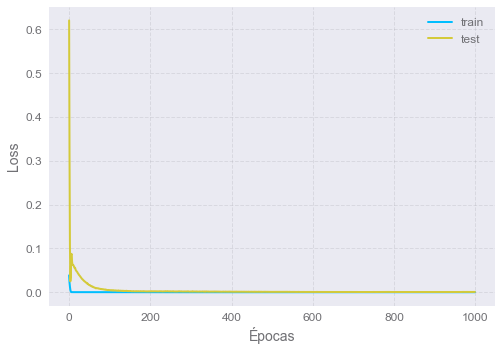

In [15]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(fontsize=12)

In [16]:
y_train_pr = model.predict(x_train_total)
y_test_pr = model.predict(x_test_total)
y_train_pr = scaler.inverse_transform(y_train_pr.reshape(-1,1))
y_test_pr = scaler.inverse_transform(y_test_pr.reshape(-1,1))
y_test =  scaler.inverse_transform(y_test_total.reshape(-1,1))
y_train = scaler.inverse_transform(y_train_total.reshape(-1,1))
print('train mse squared:',mean_squared_error(y_train_pr,y_train)) 
print('test mse squared:',mean_squared_error(y_test_pr,y_test)) 

train mse squared: 5.257118379591886
test mse squared: 257.1449007169322


# veo como se ajustan a los train y test data para distintas localidades

In [17]:
def forecast(test_data_scaled,df1,name):
    n = len(test_data_scaled)
    lag = tw
    x_input=test_data_scaled[n-lag:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    lst_output=[]
    n_steps=lag
    i=0

    while(i<10): 
        if(len(temp_input)>lag):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, 1, lag))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, 1, lag))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
    
    lst_output = scaler.inverse_transform(lst_output)
    plt.plot(lst_output,'o',label='forecast')
    plt.plot(df1,label='true data')
    plt.title(dic_localidades[str(name)])
    plt.xlabel('Días posteriores')
    plt.ylabel('Casos/100mil hab')
    plt.legend(fontsize=12)
    plt.savefig(dic_localidades[str(name)]+'_forecast.pdf')
    print('forecast error:',sum((lst_output.flatten()-df_forecast.flatten())**2))
    plt.show()

In [18]:
mae = tf.keras.losses.MeanAbsolutePercentageError()

RiesgoBariloche
train rmse: 13.76138676957794
test rmse: 62.39166243295749
train mape: 0.9985416097692872
test mape: 0.9891838959264108
train mape: 2.3735872729265934
test mape: 6.301844867376086


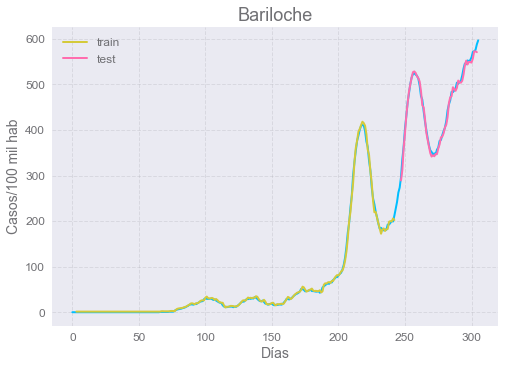

forecast error: 135198.2898335433


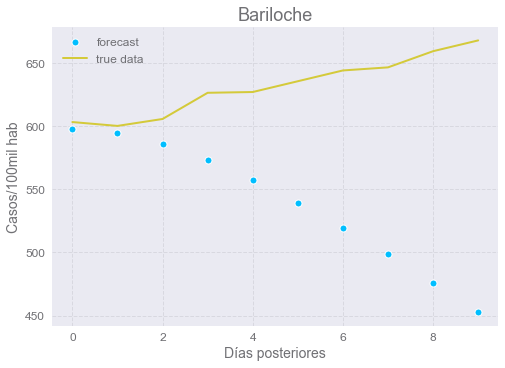

RiesgoBuenosAires
train rmse: 3.116899674801377
test rmse: 5.695353085423037
train mape: 0.999835058259494
test mape: 0.9981303342515769
train mape: 1.4260440354951067
test mape: 1.888549564310379


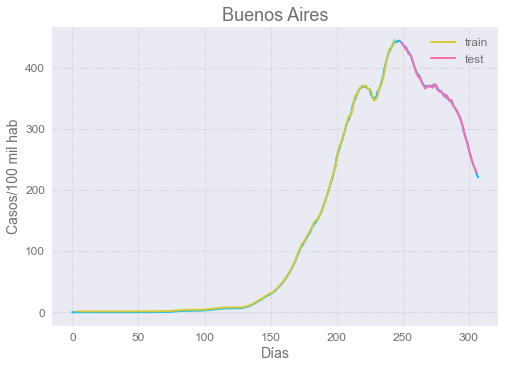

forecast error: 7183.416547106104


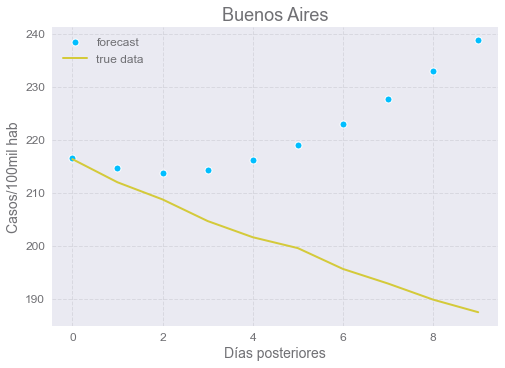

RiesgoCABACABANA
train rmse: 6.288911078506082
test rmse: 4.843511565187135
train mape: 0.9998650835335723
test mape: 0.9994118597596842
train mape: 1.819358888397595
test mape: 1.6791677761480837


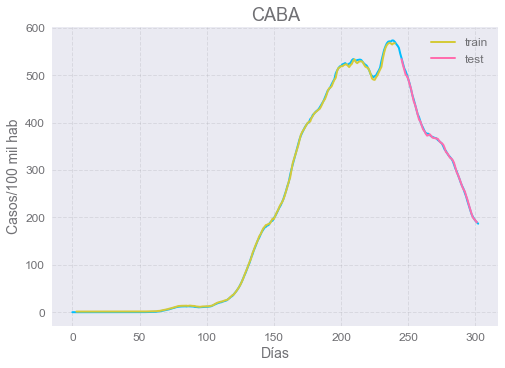

forecast error: 4640.202342964015


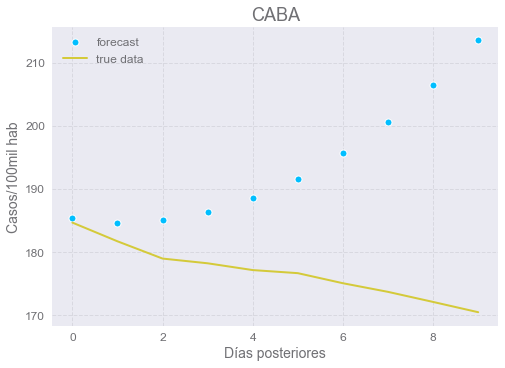

RiesgoChacoNA
train rmse: 2.7670543125146327
test rmse: 8.6125647974969
train mape: 0.9971507938559289
test mape: 0.9936499173814733
train mape: 1.4449352930464896
test mape: 2.328526929261454


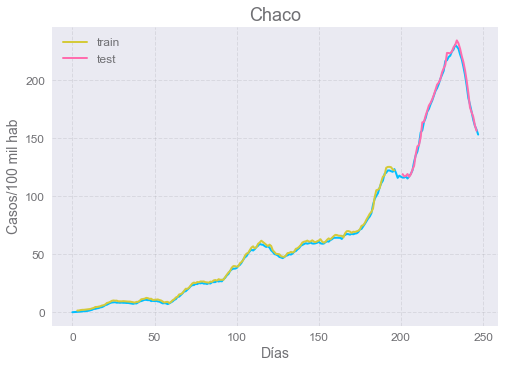

forecast error: 3985.14102665252


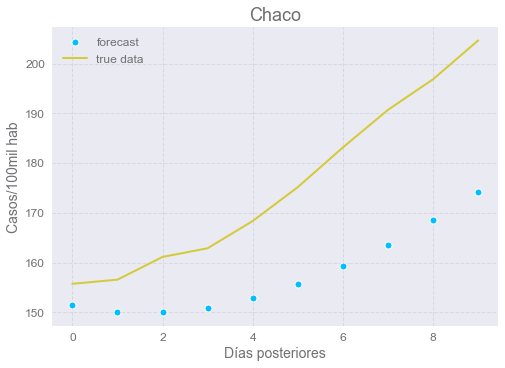

RiesgoCórdobaCórdoba
train rmse: 1.6057915676003995
test rmse: 50.383082088668054
train mape: 0.9979498109910989
test mape: 0.9982300124120151
train mape: 1.226642226970217
test mape: 5.612776847135905


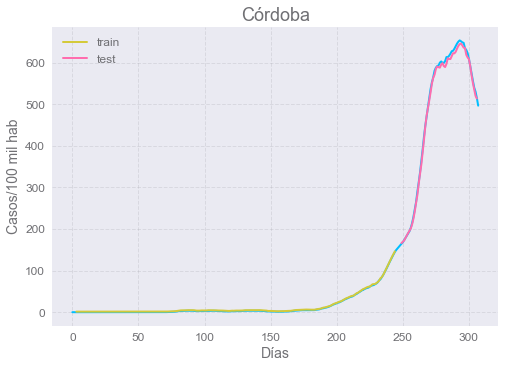

forecast error: 44124.450520153754


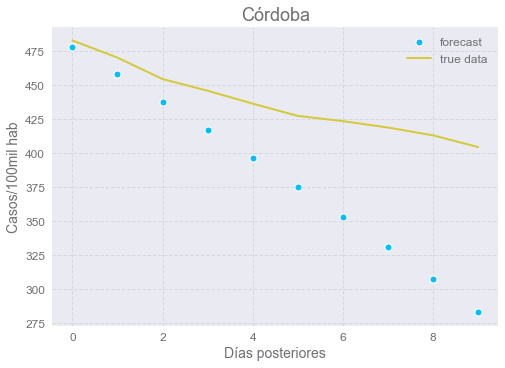

RiesgoEntreRiosRíos
train rmse: 2.3447973055269054
test rmse: 7.6248481225689195
train mape: 0.9985044072897491
test mape: 0.998875058089252
train mape: 1.3643133732786314
test mape: 2.1299527515332604


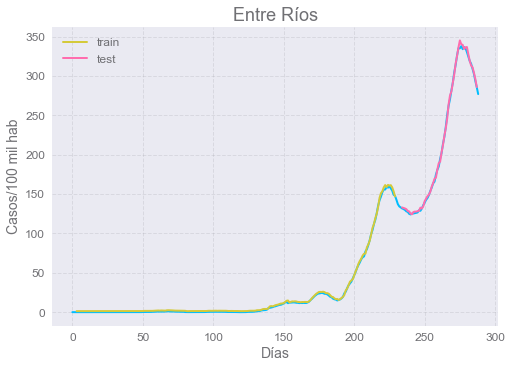

forecast error: 6146.950201645215


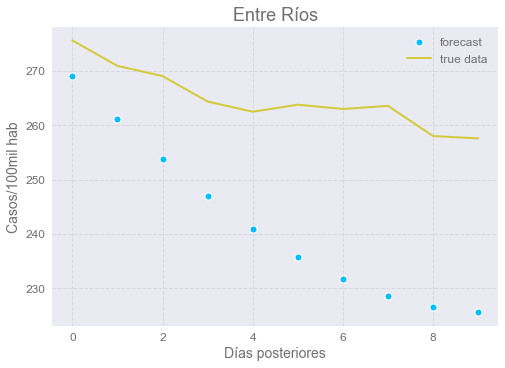

RiesgoJujuyJujuy
train rmse: 5.919197901320817
test rmse: 9.322208993651065
train mape: 0.9997845672029722
test mape: 0.9992030423965785
train mape: 1.8245456785307184
test mape: 2.4679403364784984


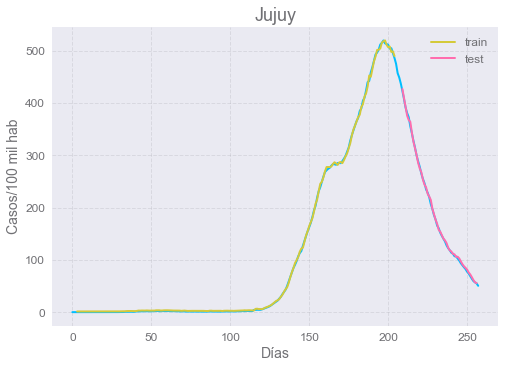

forecast error: 4326.473922668569


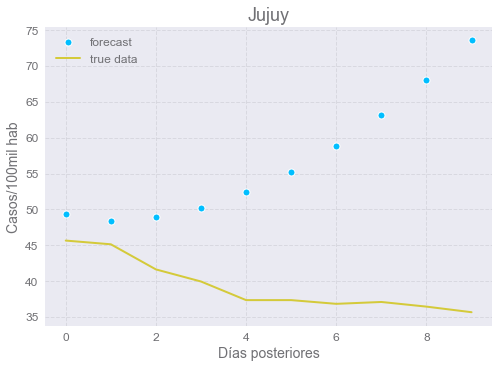

RiesgoLaRiojaRioja
train rmse: 3.980333618844133
test rmse: 39.877206653343194
train mape: 0.9992541322499853
test mape: 0.9912146301789568
train mape: 1.58297795457401
test mape: 4.922418677736407


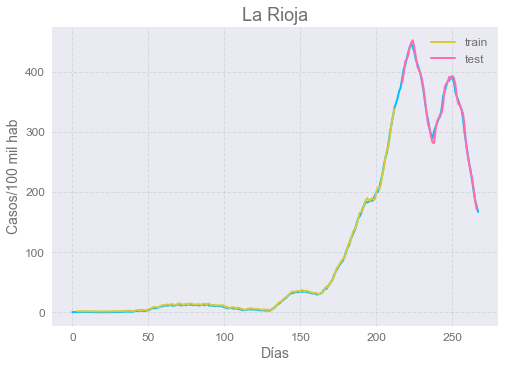

forecast error: 6021.90517397569


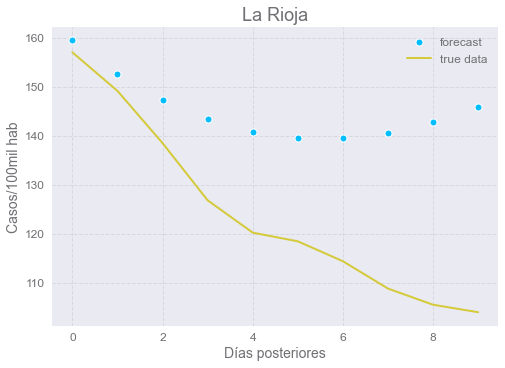

RiesgoMendozaMendoza
train rmse: 2.020882815411498
test rmse: 13.04615696843377
train mape: 0.9997877706678239
test mape: 0.9923913337812703
train mape: 1.2631927374670624
test mape: 2.8054893006952013


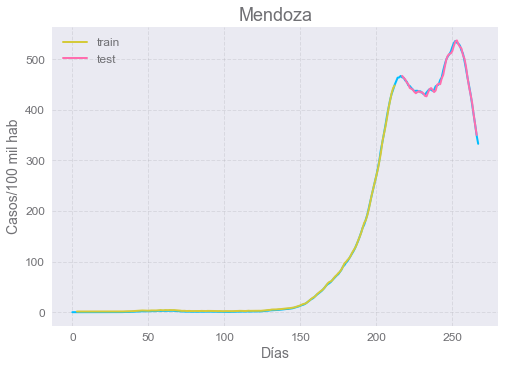

forecast error: 6521.751492711439


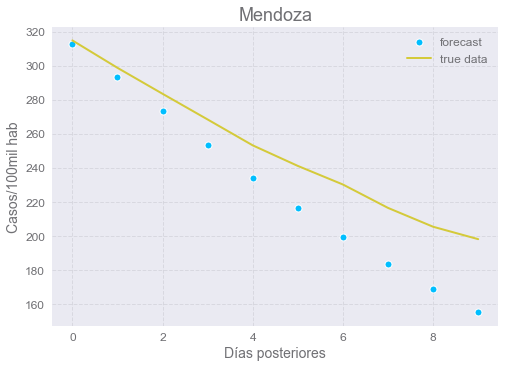

RiesgoNeuquénNeuquén
train rmse: 3.974444905224887
test rmse: 400.5415872382098
train mape: 0.9995863224362053
test mape: 0.9733863129135673
train mape: 1.559147463594339
test mape: 17.407431047641847


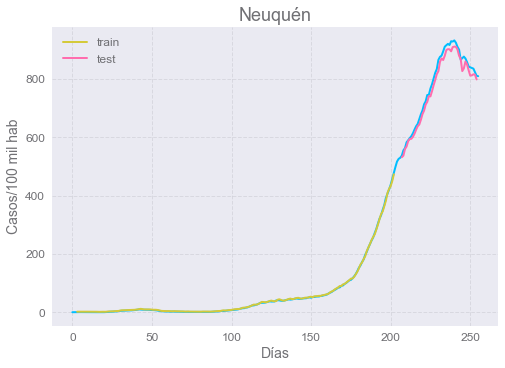

forecast error: 341175.58887820947


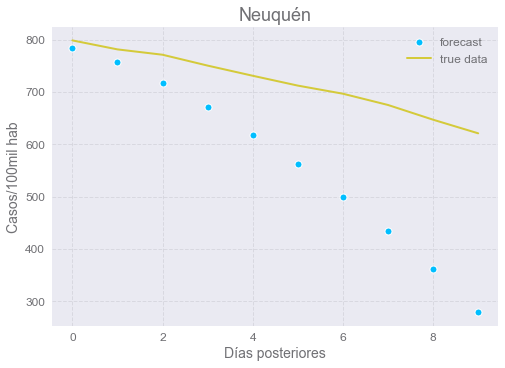

RiesgoRioNegro
train rmse: 4.001451441429691
test rmse: 117.2638012663475
train mape: 0.9994172873373897
test mape: 0.9918745141168575
train mape: 1.5599360275246184
test mape: 8.354968586479975


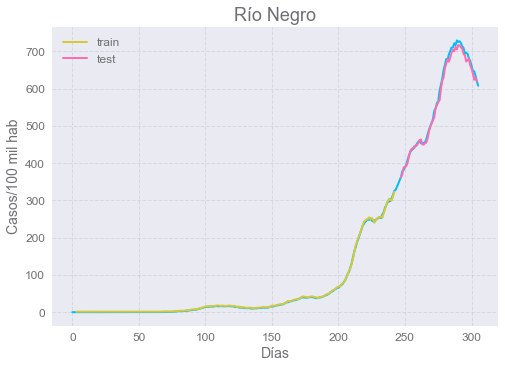

forecast error: 89363.71661622575


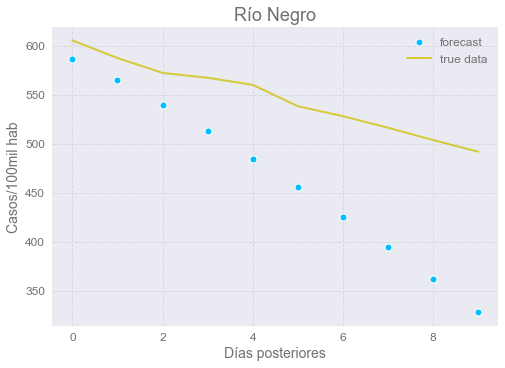

RiesgoSaltaSalta
train rmse: 2.029700873811946
test rmse: 12.876894563303969
train mape: 0.9996143768014343
test mape: 0.9974032976919628
train mape: 1.3098668744905948
test mape: 2.970700708702719


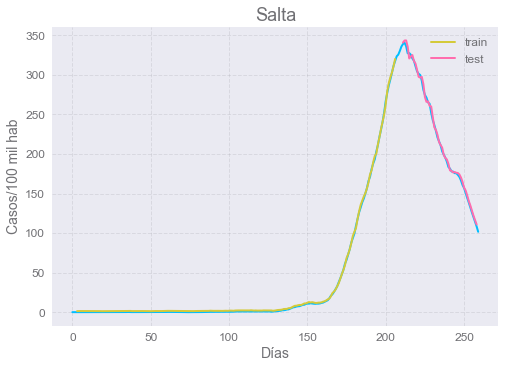

forecast error: 4617.161457382515


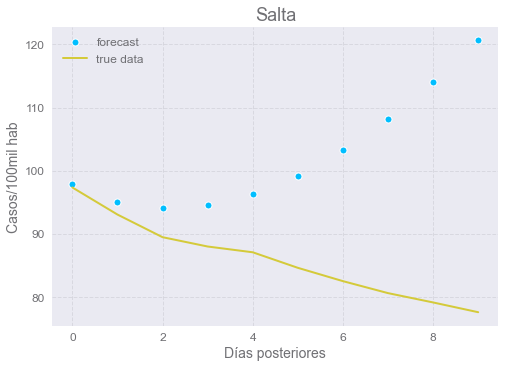

RiesgoSantaCruzSantaCruz
train rmse: 10.35056429104951
test rmse: 88.62547938070621
train mape: 0.998948840655271
test mape: 0.9913955893648261
train mape: 2.1334586217600107
test mape: 7.090460117982297


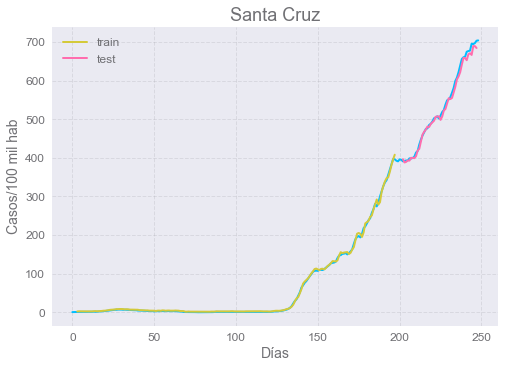

forecast error: 438100.15203368873


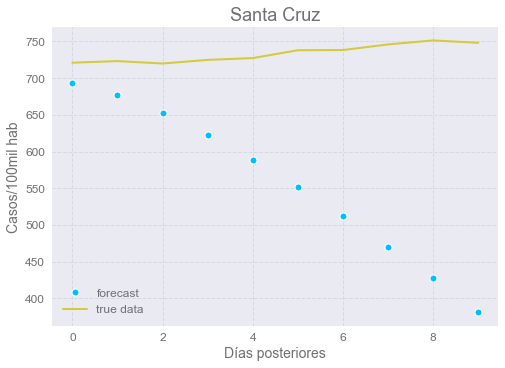

RiesgoSantaFeSantaFe
train rmse: 1.9615447590899124
test rmse: 241.4105542509569
train mape: 0.9997203045884014
test mape: 0.9827488023180704
train mape: 1.275076921945166
test mape: 14.215098708663342


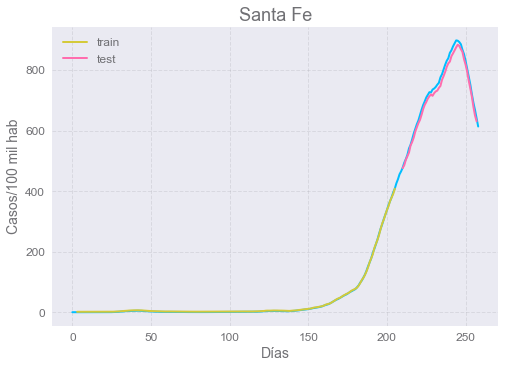

forecast error: 280909.0315937194


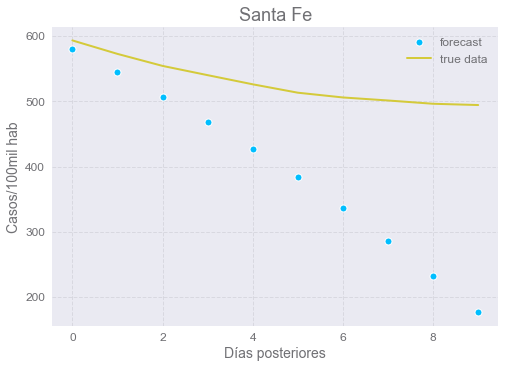

RiesgoTierradelFuegoTierradel
train rmse: 15.968621017179812
test rmse: 2494.280867233716
train mape: 0.9994434005268847
test mape: 0.9935210443208219
train mape: 2.5009079783083235
test mape: 36.05666179094475


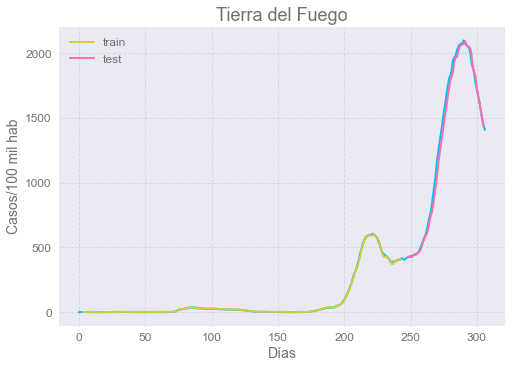

forecast error: 2088028.169987591


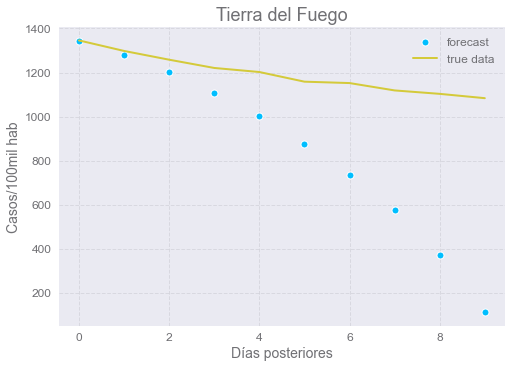

RiesgoTucumanTucuman
train rmse: 2.0135686925130662
test rmse: 342.2935675807708
train mape: 0.9997308001419772
test mape: 0.9894245603436188
train mape: 1.2982778361444105
test mape: 16.224535021731903


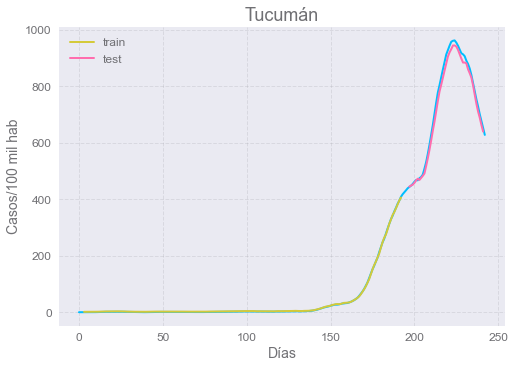

forecast error: 317531.09177382244


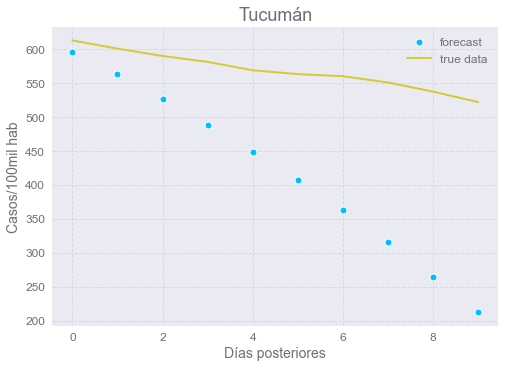

In [19]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df_forecast = df[-20:-10]
    df = df[:-20]
    df_original = np.copy(df)
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    train_data = scaler.transform(train_data.reshape(-1,1))
    test_data = scaler.transform(test_data.reshape(-1,1))
    #train
    x_train, y_train = create_dataset(train_data,tw)
    #test
    x_test, y_test = create_dataset(test_data,tw)
    x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
    x_test= x_test.reshape(x_test.shape[0],1,x_test.shape[1])
    y_train_pr = model.predict(x_train)
    y_test_pr = model.predict(x_test)
    y_train_pr = scaler.inverse_transform(y_train_pr.reshape(-1,1))
    y_test_pr = scaler.inverse_transform(y_test_pr.reshape(-1,1))
    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
    #imprimo mse para train y test
    print('train rmse:',mean_squared_error(y_train,y_train_pr)) 
    print('test rmse:',mean_squared_error(y_test,y_test_pr))
    #imprimo r2
    print('train mape:',r2_score(y_train,y_train_pr)) 
    print('test mape:',r2_score(y_test,y_test_pr)) 
    #imprimo mae
    print('train mape:',mean_absolute_error(y_train,y_train_pr)) 
    print('test mape:',mean_absolute_error(y_test,y_test_pr)) 
    graph_predictions(tw,df_original,y_train_pr,y_test_pr,file)
    forecast(test_data,df_forecast,file)